1. Download the MNIST dataset using torchvision.datasets.

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


train_dataset = dsets.MNIST(root="./MNIST",
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

5.6%

100.0%


Extracting ./MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\MNIST\raw


100.0%
7.9%


Extracting ./MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw



100.0%
100.0%


Extracting ./MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\MNIST\raw

Extracting ./MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw



2. Create a generator that takes as input a random vector with noise and generates an image of MNIST digits.

In [2]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=16, out_features=32)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)   
        self.fc3 = nn.Linear(in_features=32, out_features=64)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=64, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

3. Create a discriminator that takes as input an image of MNIST digits and determines whether it is a real image or generated by a generator.

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=64)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=32, out_features=16)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=16, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

4. Train the model to generate new images of MNIST digits using the interaction of the generator and the discriminator using the GAN (adversarial loss) loss function.

In [4]:
import torch.optim as optim
import numpy as np
import dill as pkl

image_batch = next(iter(data_loader))
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))


def real_loss(predicted_outputs, loss_fn, device):
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss


def train_minst_gan(d, g, d_optim, g_optim, loss_fn, data_loader, n_epochs, device, verbose=False):
    print(f"Training on [{device}]...")
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    d = d.to(device)
    g = g.to(device)
    for epoch in range(n_epochs):
        print(f"Epoch [{epoch+1}/{n_epochs}]:")
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(data_loader):
            real_images = real_images.to(device)
            d_optim.zero_grad()
            real_images = (real_images * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(data_loader.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                fake_images = g(z) 
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()
            d_running_batch_loss += d_loss
            g_optim.zero_grad()
            z = np.random.uniform(-1, 1, size=(data_loader.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            g_loss.backward()
            g_optim.step()
            g_running_batch_loss += g_loss
            if curr_batch % 400 == 0 and verbose:
                print(f"\tBatch [{curr_batch:>4}/{len(data_loader):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}")
            
        d_epoch_loss = d_running_batch_loss.item()/len(data_loader)
        g_epoch_loss = g_running_batch_loss.item()/len(data_loader)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        print(f"epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}")
        
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    with open("fixed_samples.pkl", "wb") as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses


d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)

d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

loss_fn = nn.BCEWithLogitsLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"

n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, 
                                     loss_fn, data_loader, n_epochs, device,
                                     verbose=False)

Training on [cpu]...
Epoch [1/100]:
epoch_d_loss: 1.119165 	epoch_g_loss: 1.448492
Epoch [2/100]:
epoch_d_loss: 1.135644 	epoch_g_loss: 1.193543
Epoch [3/100]:
epoch_d_loss: 1.052386 	epoch_g_loss: 1.193854
Epoch [4/100]:
epoch_d_loss: 1.057714 	epoch_g_loss: 1.224452
Epoch [5/100]:
epoch_d_loss: 1.207060 	epoch_g_loss: 1.037394
Epoch [6/100]:
epoch_d_loss: 1.114121 	epoch_g_loss: 1.111028
Epoch [7/100]:
epoch_d_loss: 1.205528 	epoch_g_loss: 0.982665
Epoch [8/100]:
epoch_d_loss: 1.257083 	epoch_g_loss: 0.899556
Epoch [9/100]:
epoch_d_loss: 1.261069 	epoch_g_loss: 0.874321
Epoch [10/100]:
epoch_d_loss: 1.219260 	epoch_g_loss: 0.935086
Epoch [11/100]:
epoch_d_loss: 1.264225 	epoch_g_loss: 0.885737
Epoch [12/100]:
epoch_d_loss: 1.257604 	epoch_g_loss: 0.881145
Epoch [13/100]:
epoch_d_loss: 1.243302 	epoch_g_loss: 0.918474
Epoch [14/100]:
epoch_d_loss: 1.220085 	epoch_g_loss: 0.943831
Epoch [15/100]:
epoch_d_loss: 1.222446 	epoch_g_loss: 0.944305
Epoch [16/100]:
epoch_d_loss: 1.226997 	epo

5. After training, output some generated images and compare them with the original images from the MNIST dataset.

epoch 1:


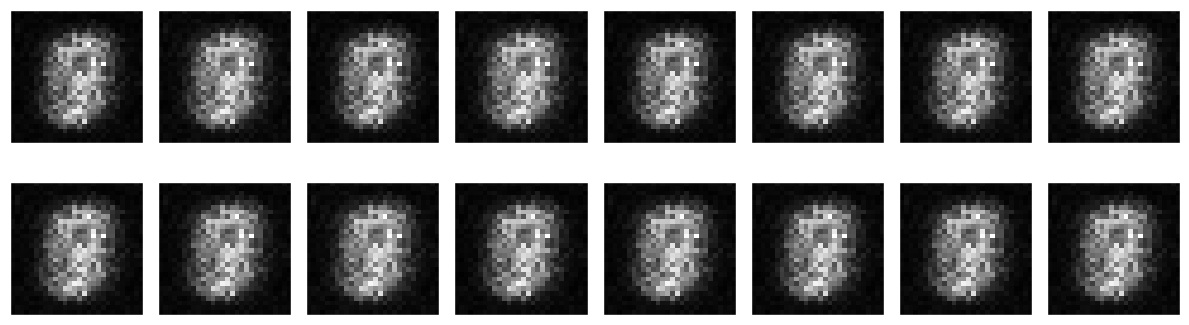

epoch 10:


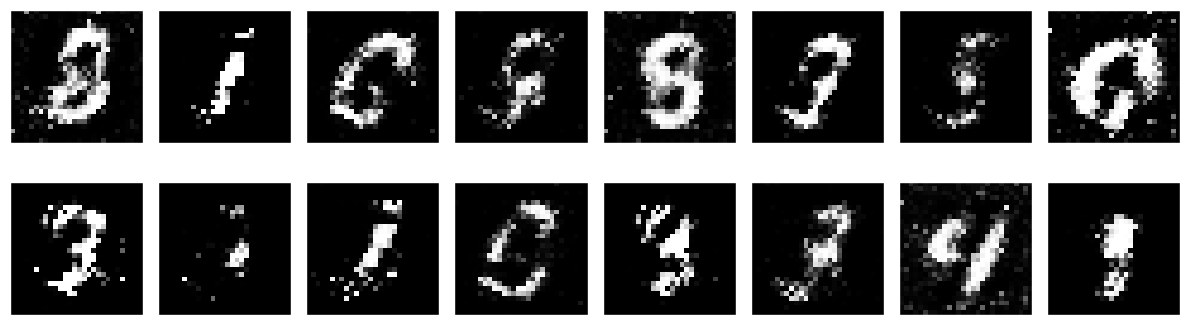

epoch 20:


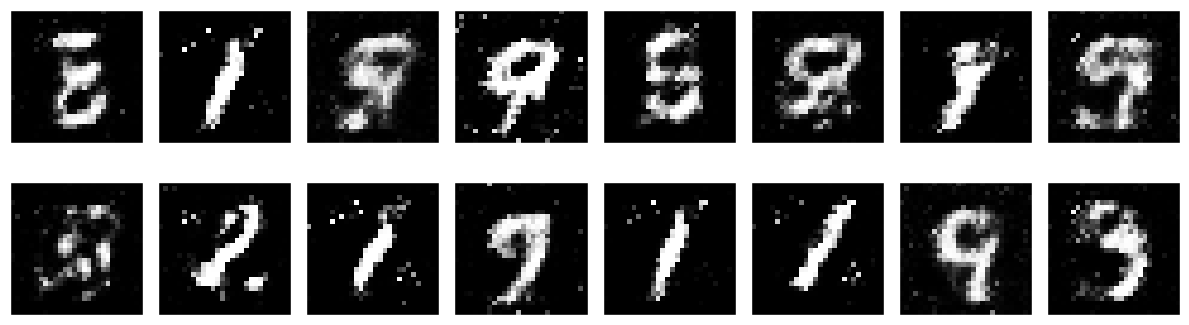

epoch 30:


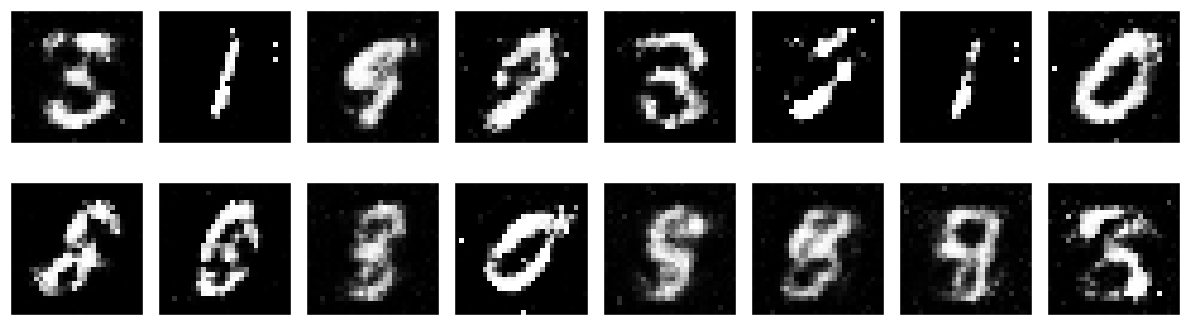

epoch 40:


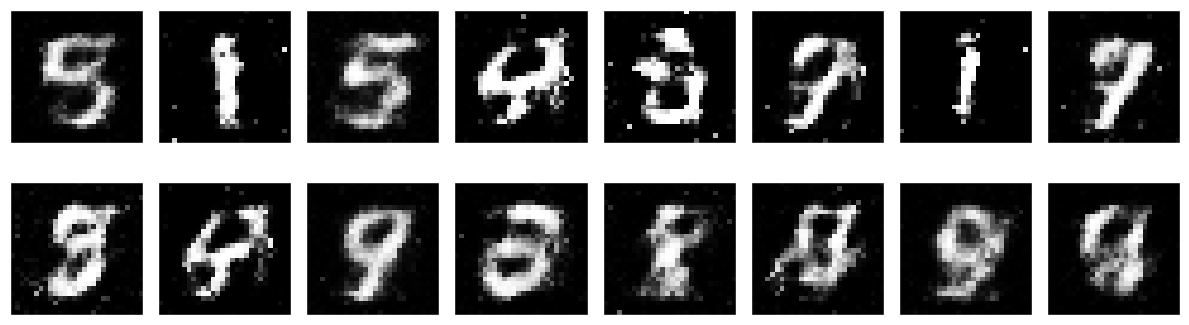

epoch 50:


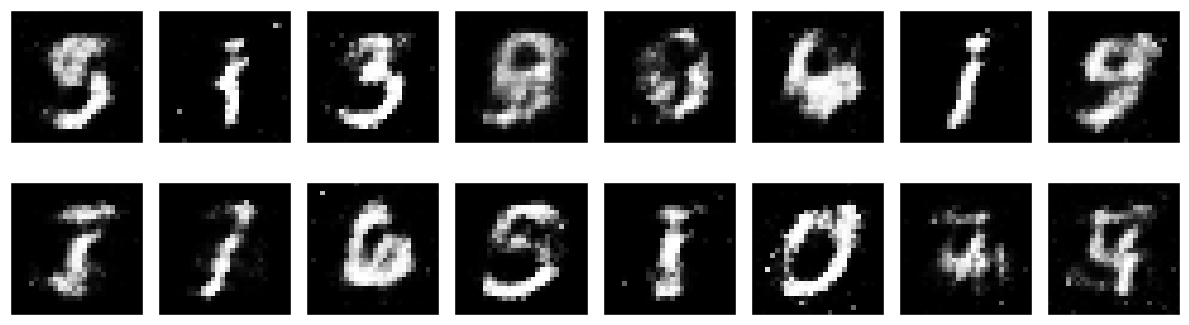

epoch 60:


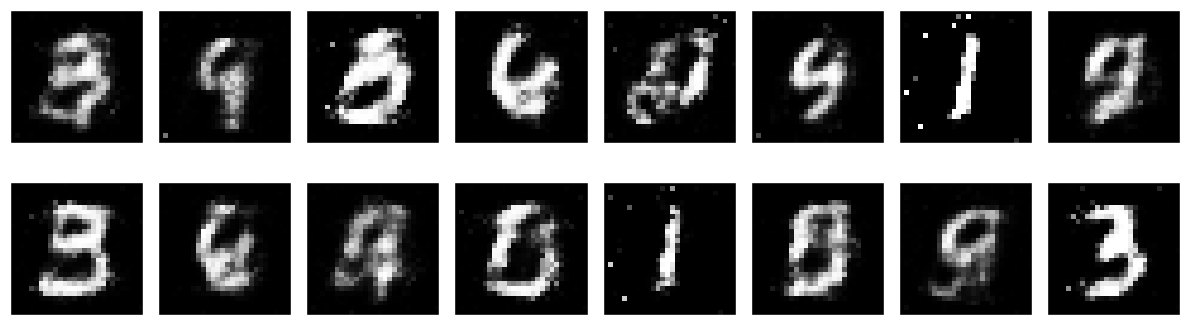

epoch 70:


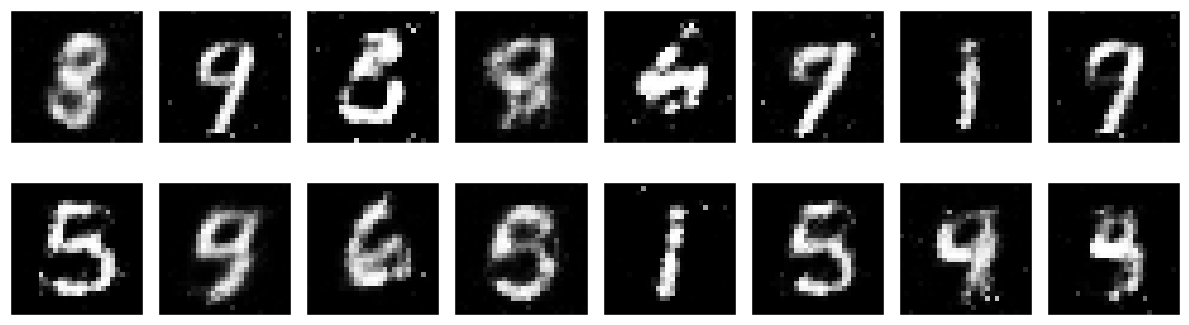

epoch 80:


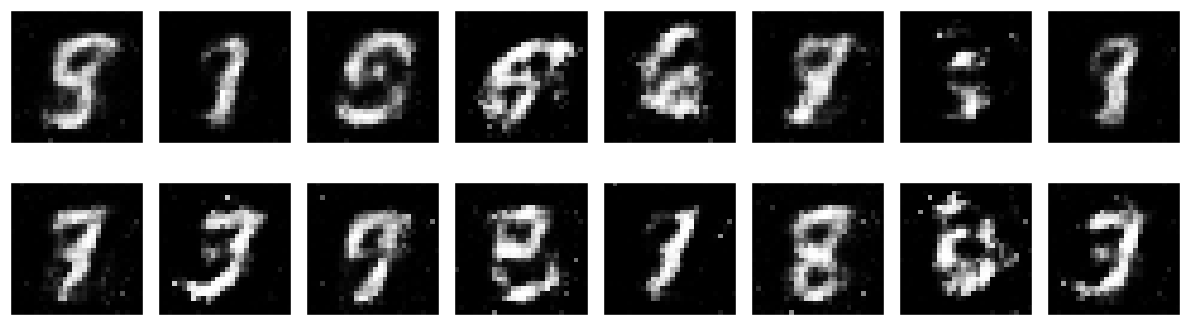

epoch 90:


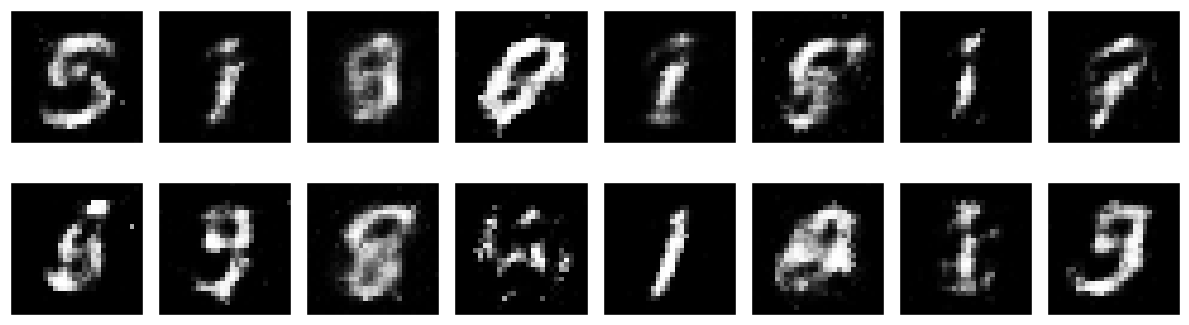

epoch 100:


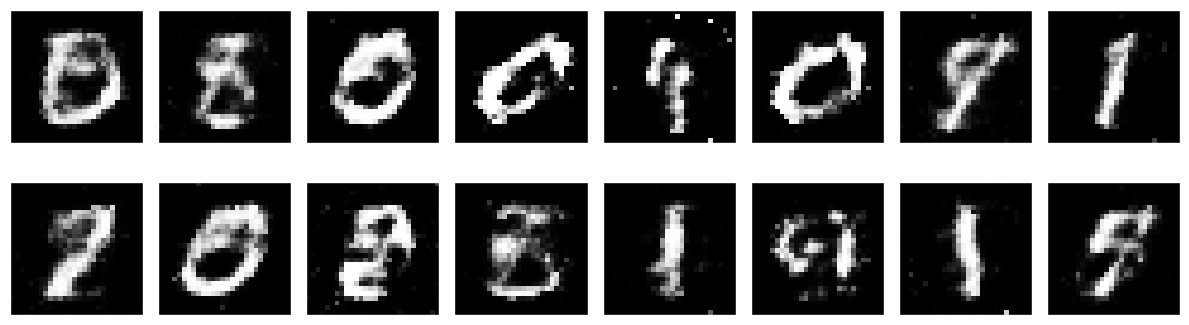

In [5]:
import math
import matplotlib.pyplot as plt


def display_images(images, n_cols=4, figsize=(12, 6)):
    plt.style.use("ggplot")
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        image = image.permute(1, 2, 0)
        cmap = "gray" if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()
    

def show_generated_images(epoch, n_cols=8):
    with open("fixed_samples.pkl", "rb") as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    epoch_data = (epoch_data + 1) / 2
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))


print("epoch 1:")
show_generated_images(epoch=1, n_cols=8)
print("epoch 10:")
show_generated_images(epoch=10, n_cols=8)
print("epoch 20:")
show_generated_images(epoch=20, n_cols=8)
print("epoch 30:")
show_generated_images(epoch=30, n_cols=8)
print("epoch 40:")
show_generated_images(epoch=40, n_cols=8)
print("epoch 50:")
show_generated_images(epoch=50, n_cols=8)
print("epoch 60:")
show_generated_images(epoch=60, n_cols=8)
print("epoch 70:")
show_generated_images(epoch=70, n_cols=8)
print("epoch 80:")
show_generated_images(epoch=80, n_cols=8)
print("epoch 90:")
show_generated_images(epoch=90, n_cols=8)
print("epoch 100:")
show_generated_images(epoch=100, n_cols=8)

# Original to compare with:

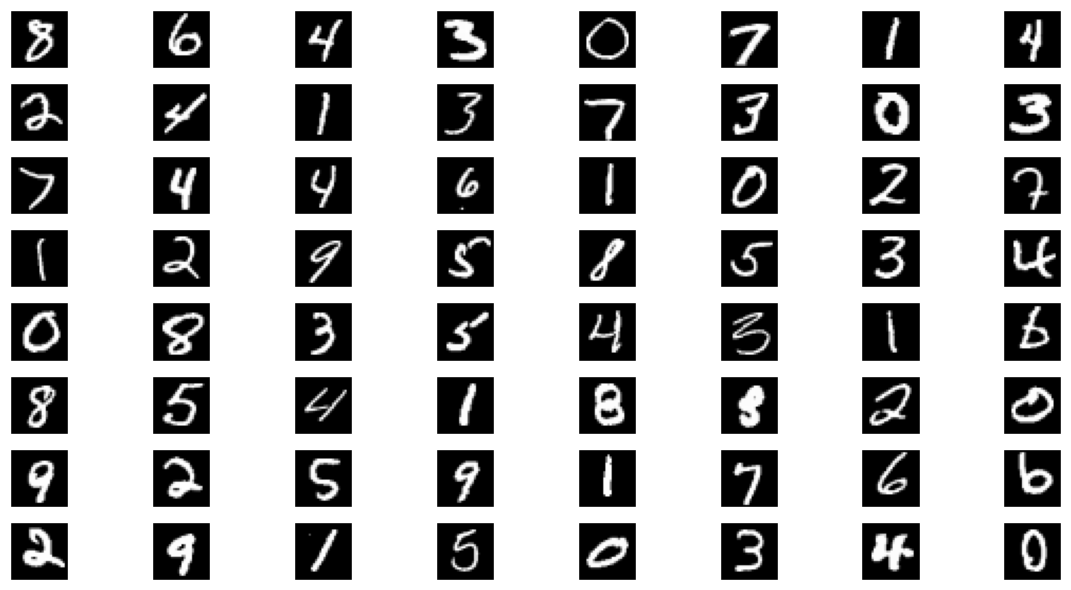

In [6]:
display_images(images=image_batch[0], n_cols=8)